In [33]:

# dataset from https://www.kaggle.com/datasets/kasikrit/att-database-of-faces?resource=download
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from keras import layers
# import tensorflow_addons as tfa
#import keras one hot encoder
from keras.utils import to_categorical
import torch
import torch.nn as nn
import time
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torch.utils.data import TensorDataset

directory="dataset"



def loadImages(folder, y):
    images = []
    labels = []
    pics = os.listdir(folder)
    for pic in pics:
        img = cv2.imread(os.path.join(folder,pic))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transform to grayscale
        if img is not None:
            images.append(img)
            labels.append(y)
    return images, labels


def load_images_from_folder(folder):
    images = []
    labels = []
    dirs = os.listdir(folder)
    dirs.remove("README")
    for directory in dirs:
        y = directory[1:]
        path = os.path.join(folder, directory)
        i, l = loadImages(path, y)
        images = images + i 
        labels = labels + l
    images = np.array(images) 
    images = images.reshape(images.shape[0],images.shape[1] * images.shape[2])
    labels = np.array(labels)
    return images, labels

images, labels = load_images_from_folder(directory)
#reshape images
# images = images.reshape(images.shape[0], 112, 92, 1)
# images=np.expand_dims(images, axis=2)
images=images.astype('float32')
#normalize images
images /= 255
labels=to_categorical(labels)
#convert labelst integer encoded
labels = np.argmax(labels, axis=1)


#shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]


#split data
X_train = images[:int(images.shape[0]*0.8)]
y_train = labels[:int(labels.shape[0]*0.8)]
X_test = images[int(images.shape[0]*0.8):]
y_test = labels[int(labels.shape[0]*0.8):]


# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.05
NUM_EPOCHS = 20
BATCH_SIZE = 32
BATCH_SIZE=16
IN_SHAPE=X_train.shape[1]
# Architecture
NUM_CLASSES = 41

X_train = torch.Tensor(X_train) # transform to torch tensor
y_train = torch.Tensor(y_train) # transform to torch tensor
train_dataset = TensorDataset(X_train,y_train) # create your datset



X_test = torch.Tensor(X_test) # transform to torch tensor
y_test = torch.Tensor(y_test) # transform to torch tensor
test_dataset = TensorDataset(X_test,y_test) # create your datset

train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                        #   num_workers=4,
                          shuffle=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE,
                        #  num_workers=4,
                         shuffle=False)

In [34]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(IN_SHAPE, int(IN_SHAPE/10)),
            nn.Tanh(),
            # nn.Linear(5000, 500),
            # nn.ReLU(inplace=True),
            nn.Linear(int(IN_SHAPE/10), NUM_CLASSES))

    def forward(self, x):
        logits = self.fc1(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas


torch.manual_seed(RANDOM_SEED)
model = SiameseNetwork()

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

In [35]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        # logits= logits.to(torch.short)
        cost = F.cross_entropy(logits, targets.long())
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')


    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, test_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc.cpu().numpy())
        valid_acc_list.append(valid_acc.cpu().numpy())
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/020 | Cost: 3.7291
Epoch: 001/020
Train ACC: 2.81 | Validation ACC: 1.25
Time elapsed: 0.01 min
Epoch: 002/020 | Batch 000/020 | Cost: 5.4059
Epoch: 002/020
Train ACC: 2.81 | Validation ACC: 1.25
Time elapsed: 0.01 min
Epoch: 003/020 | Batch 000/020 | Cost: 4.6433
Epoch: 003/020
Train ACC: 38.12 | Validation ACC: 17.50
Time elapsed: 0.01 min
Epoch: 004/020 | Batch 000/020 | Cost: 2.1817
Epoch: 004/020
Train ACC: 47.81 | Validation ACC: 25.00
Time elapsed: 0.01 min
Epoch: 005/020 | Batch 000/020 | Cost: 1.5641
Epoch: 005/020
Train ACC: 63.13 | Validation ACC: 33.75
Time elapsed: 0.01 min
Epoch: 006/020 | Batch 000/020 | Cost: 1.1993
Epoch: 006/020
Train ACC: 77.50 | Validation ACC: 48.75
Time elapsed: 0.01 min
Epoch: 007/020 | Batch 000/020 | Cost: 0.9799
Epoch: 007/020
Train ACC: 87.19 | Validation ACC: 58.75
Time elapsed: 0.02 min
Epoch: 008/020 | Batch 000/020 | Cost: 0.6664
Epoch: 008/020
Train ACC: 91.56 | Validation ACC: 62.50
Time elapsed: 0.02 min
Epoc

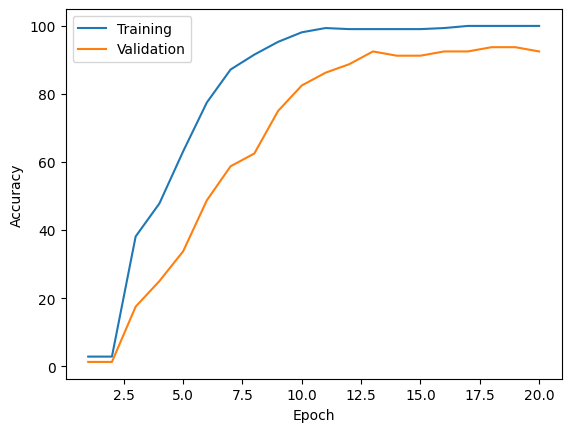

In [36]:
#copy tensor tom
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

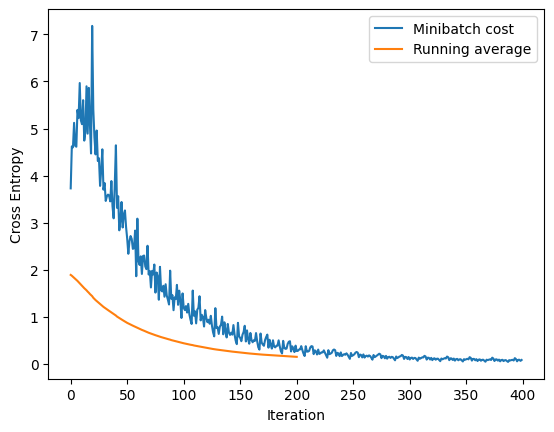

In [37]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [38]:
from torch.autograd import Variable

def Process(im_flatten):
    maxValue = torch.max(im_flatten)
    minValue = torch.min(im_flatten)
    im_flatten = im_flatten-minValue
    im_flatten = im_flatten/(maxValue-minValue)
    return im_flatten


#bring model to device
model = model.to("cpu")

target_label=labels[0:1]
print("Destined Class:",target_label[0])
target_label=torch.Tensor(target_label)
classes = 40
alpha = 500
beta = 1000
gama = 0.001
learning_rate = 0.1
momentum = 0.5

aim_flatten = torch.zeros(1, 112*92)
v = torch.zeros(1, 112*92)
aim_flatten.requires_grad = True
costn_1 = 10
b = 0
g = 0
out,_ = model.forward(aim_flatten.detach())
after_softmax = F.softmax(out, dim=-1)
predict = torch.argmax(after_softmax)
print("Prediction Class at 0th Iteration:",predict.item())
for i in range(alpha):
    out,_ =model.forward(aim_flatten)
    if aim_flatten.grad is not None:
        aim_flatten.grad.zero_()

    out = out.reshape(1, 41)
    target_class = torch.tensor([target_label])
    cost = nn.CrossEntropyLoss()(out, target_class.long())
    cost.backward()
    aim_grad = aim_flatten.grad
    aim_flatten = aim_flatten-learning_rate*(momentum*v+aim_grad)
    aim_flatten = Process(aim_flatten)
    aim_flatten = torch.clamp(aim_flatten.detach(), 0, 1)
    aim_flatten.requires_grad = True
    if cost >= costn_1:
        b = b+1
        if b > beta:
            break
    else:
        b = 0
    costn_1 = cost
    if cost < gama:
        break
out,_ = model.forward(aim_flatten.detach())
after_softmax = F.softmax(out, dim=-1)
predict = torch.argmax(after_softmax)
#convert predict to scalar
predict = predict.item()
print("Finally Converged Class:",predict)
oim_flatten = aim_flatten.detach()
output_image = oim_flatten.reshape(112, 92)
output_image = output_image*255

Destined Class: 7
Prediction Class at 0th Iteration: 22
Finally Converged Class: 7


Text(0.5, 1.0, 'Original Image')

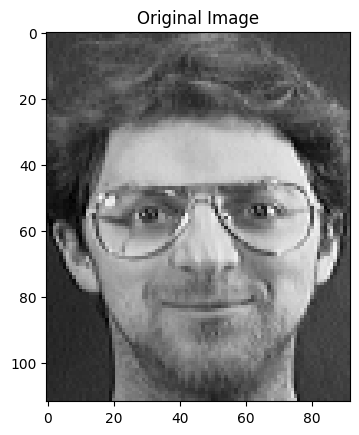

In [39]:
ref_image=images[0:1]
ref_image=ref_image.reshape(112,92)
ref_image=ref_image*255
plt.imshow(ref_image, cmap='gray')
plt.title("Original Image")

Text(0.5, 1.0, 'Reconstructed Image')

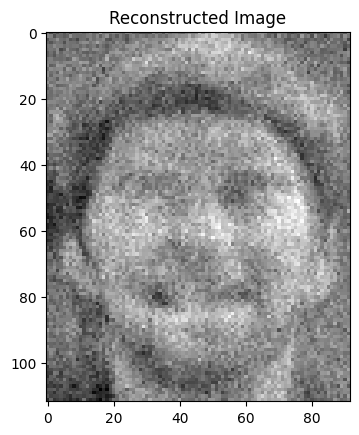

In [40]:
plt.imshow(output_image, cmap='gray')
plt.title("Reconstructed Image")